In [2]:
import pandas as pd
import numpy as np
   
from sklearn.linear_model import LinearRegression,Ridge, Lasso, LassoCV
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score, mean_squared_error,make_scorer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler


import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# import lightgbm
# from lightgbm import LGBMRegressor


import warnings
warnings.simplefilter('ignore')

In [3]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [4]:
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

# setting some globl config
plt.style.use('ggplot')
orange_black = [
    '#fdc029', '#df861d', '#FF6347', '#aa3d01', '#a30e15', '#800000', '#171820'
]
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams["figure.facecolor"] = '#FFFACD'
plt.rcParams["axes.facecolor"] = '#FFFFE0'
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.color"] = orange_black[3]
plt.rcParams["grid.alpha"] = 0.5
plt.rcParams["grid.linestyle"] = '--'

In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.4f}'.format)
pd.options.display.max_colwidth = 200

# 1. Read data

In [30]:
df = pd.read_excel('MMM_Blender_data_2.xlsx')

In [31]:
# # Remove ($) in column names; lower case column names
# df.rename(columns=lambda x: x.replace(' ($)','').replace(" ", "_").lower(), inplace=True)

# Drop 'month' column
df.drop(columns=['Date'],inplace=True)# # Remove ($) in column names; lower case column names
df.rename(columns=lambda x: x.replace(' ($)','').replace(" ", "_").lower(), inplace=True)

In [32]:
df.head()

,sales,tv_ads,online_ads,print_ads,price
0,6237000,181222.5484,12152.5401,24986.9128,135.0000
1,6115500,179104.3532,57353.3764,17574.3854,135.0000
2,10577250,222756.2232,146794.2454,16016.0229,135.0000
3,13473000,188266.8183,376459.4682,29689.6942,135.0000
4,6258525,210038.2897,21297.5732,17606.9914,136.5000


# 2. EDA

## 2.1 Check missing values

In [33]:
# Check missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sales       150 non-null    int64  
 1   tv_ads      150 non-null    float64
 2   online_ads  150 non-null    float64
 3   print_ads   150 non-null    float64
 4   price       150 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


## 2.2 Check 'sales' distribution

In [34]:
df['sales'].describe()

count        150.0000
mean     7387596.0000
std      2794340.8745
min       785400.0000
25%      5835768.7500
50%      7635600.0000
75%      9482625.0000
max     13802250.0000
Name: sales, dtype: float64

In [10]:
#histogram
#sns.histplot(df['sales'],kde=True, stat="density")
#plt.show()

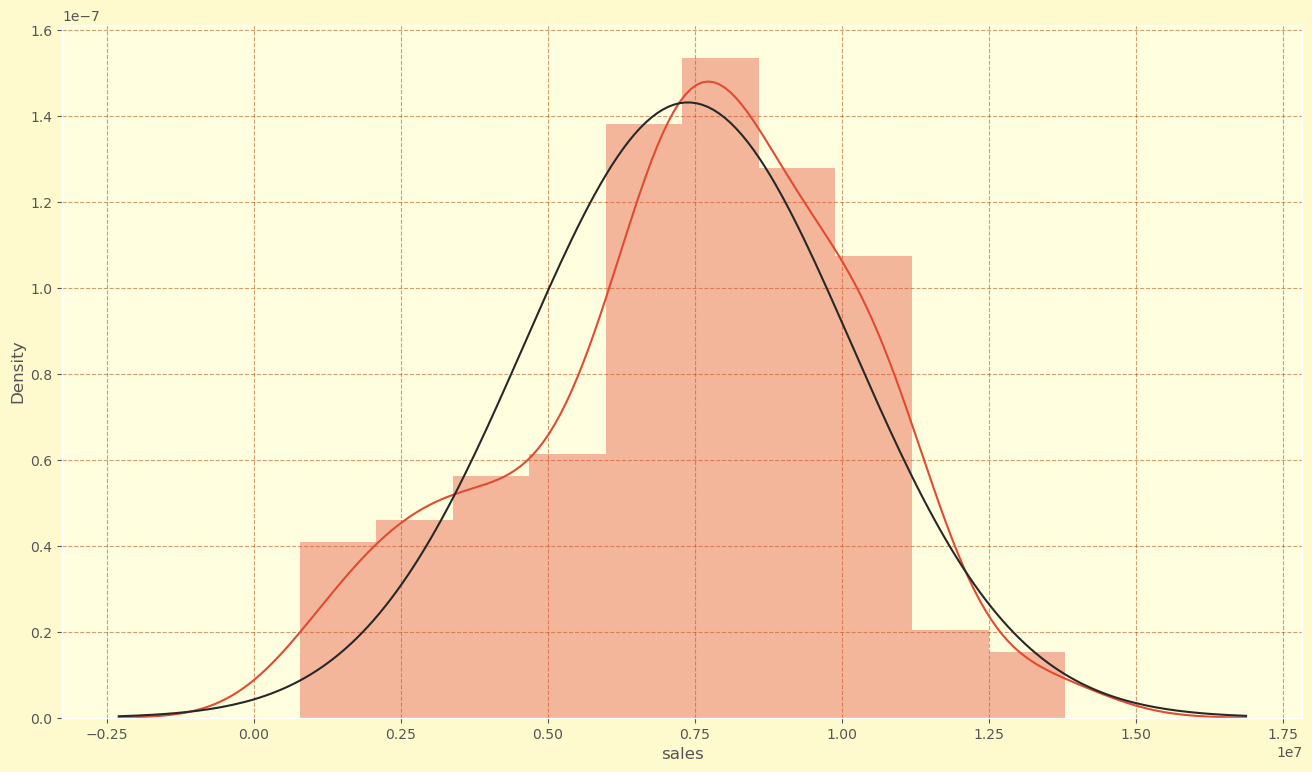

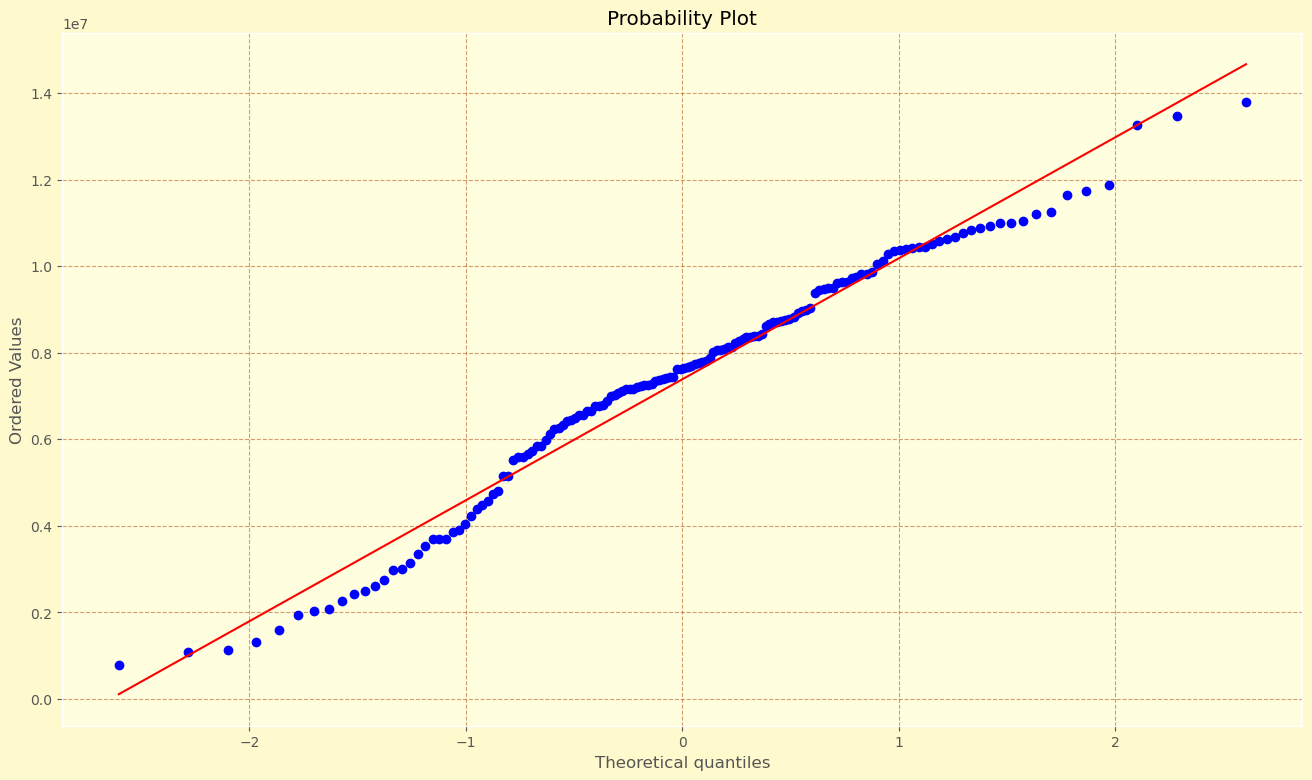

In [35]:
sns.distplot(df['sales'], fit=norm)
plt.show()
res = stats.probplot(df['sales'], plot=plt)

In [36]:
#skewness and kurtosis
print(f"Skewness of 'sales': {df['sales'].skew():.6f}")
print(f"Kurtosis of 'sales': {df['sales'].kurt():.6f}")

Skewness of 'sales': -0.371289
Kurtosis of 'sales': -0.278691


**Insights: The distribution of 'sales' is close to normal distribution**

## 2.3 Relationship between 'sales' and other features

In [69]:
features = ['tv_ads', 'online_ads', 'print_ads', 'price']

In [70]:
features

['tv_ads', 'online_ads', 'print_ads', 'price']

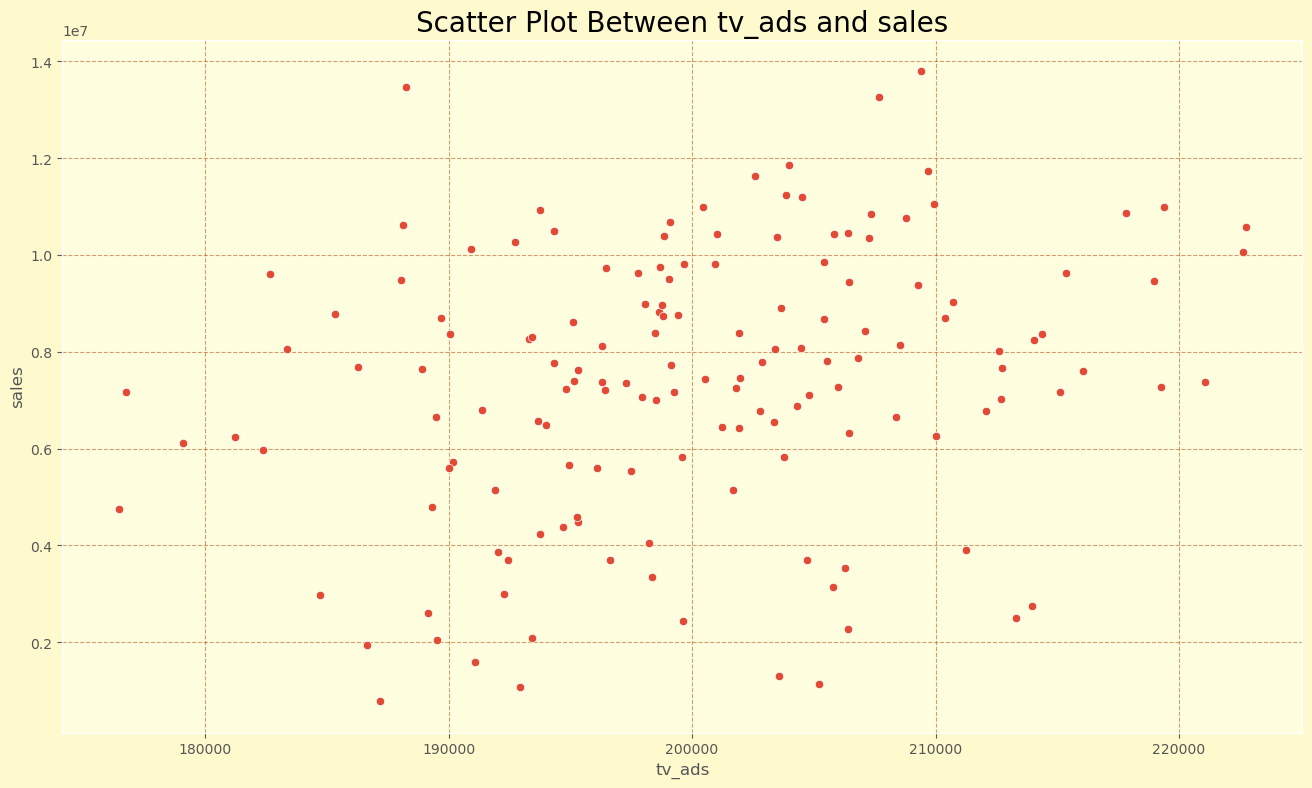

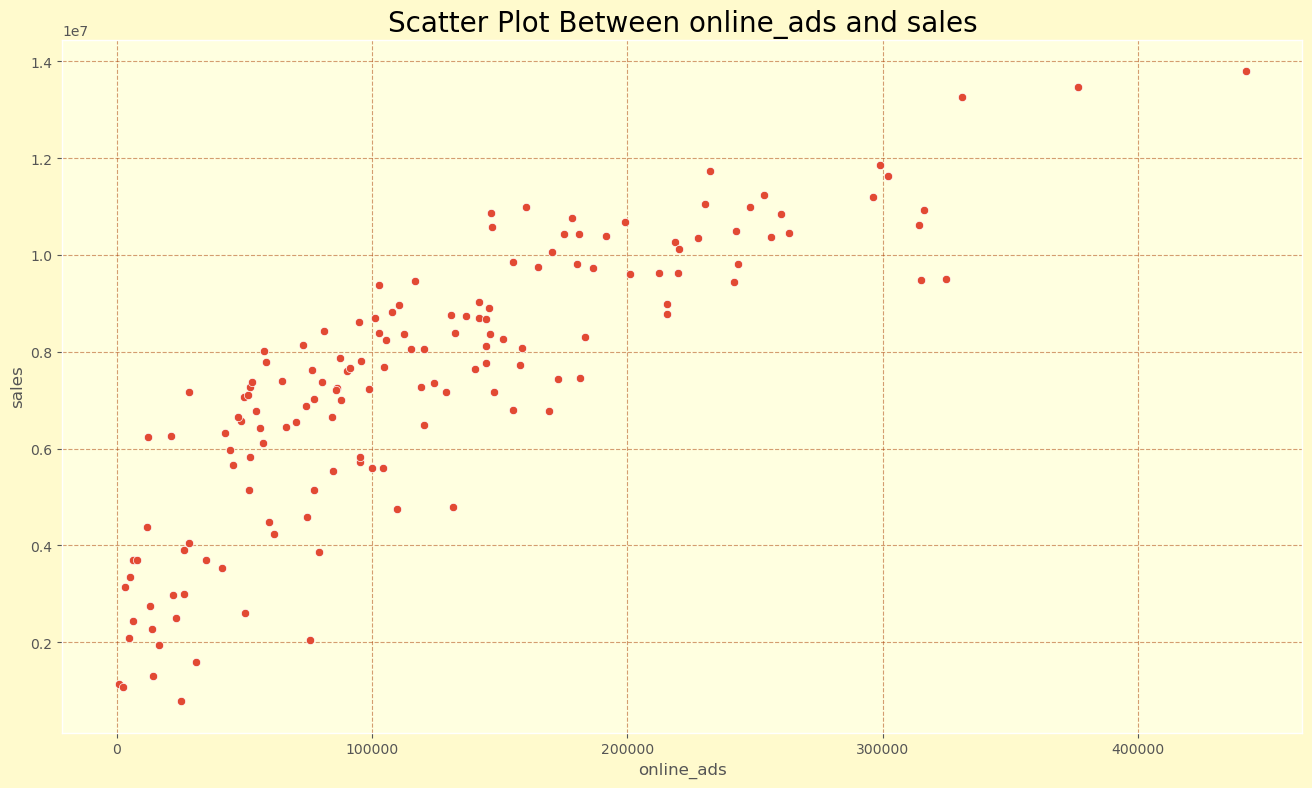

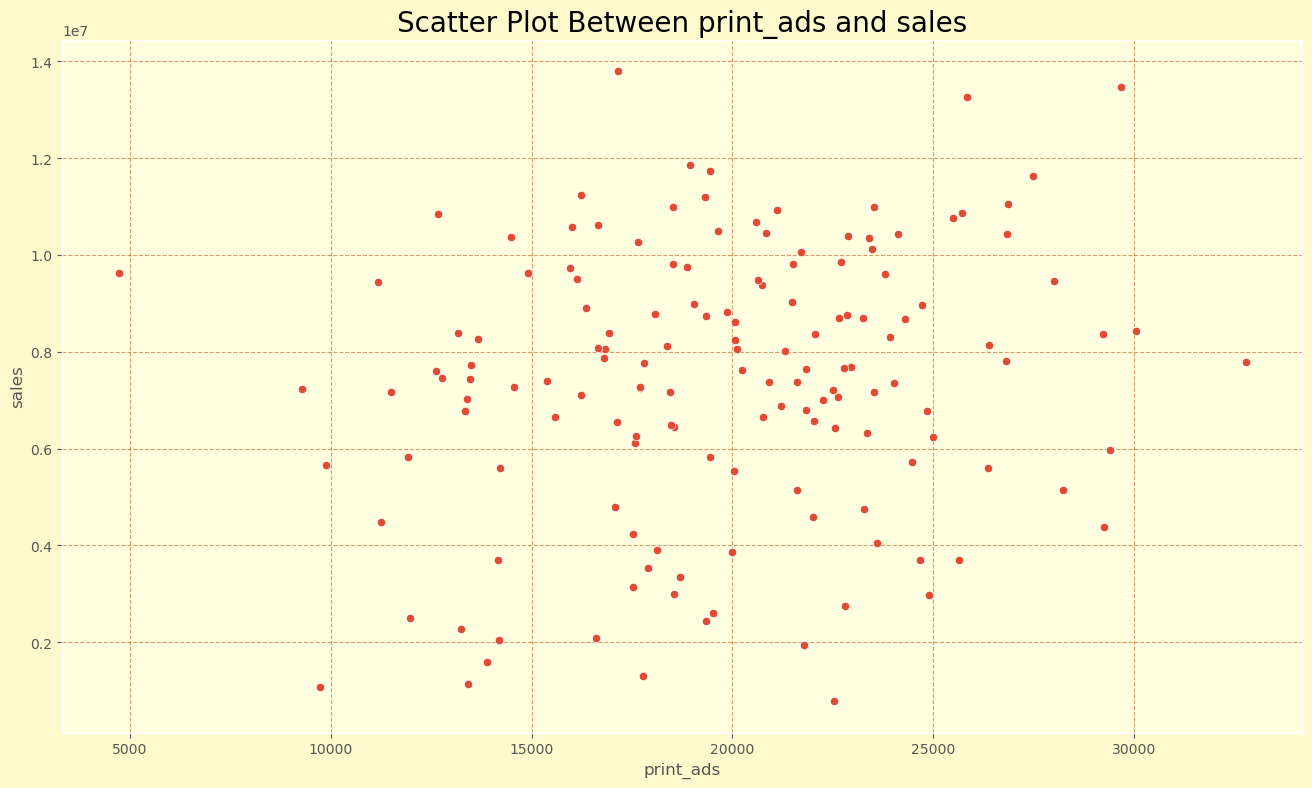

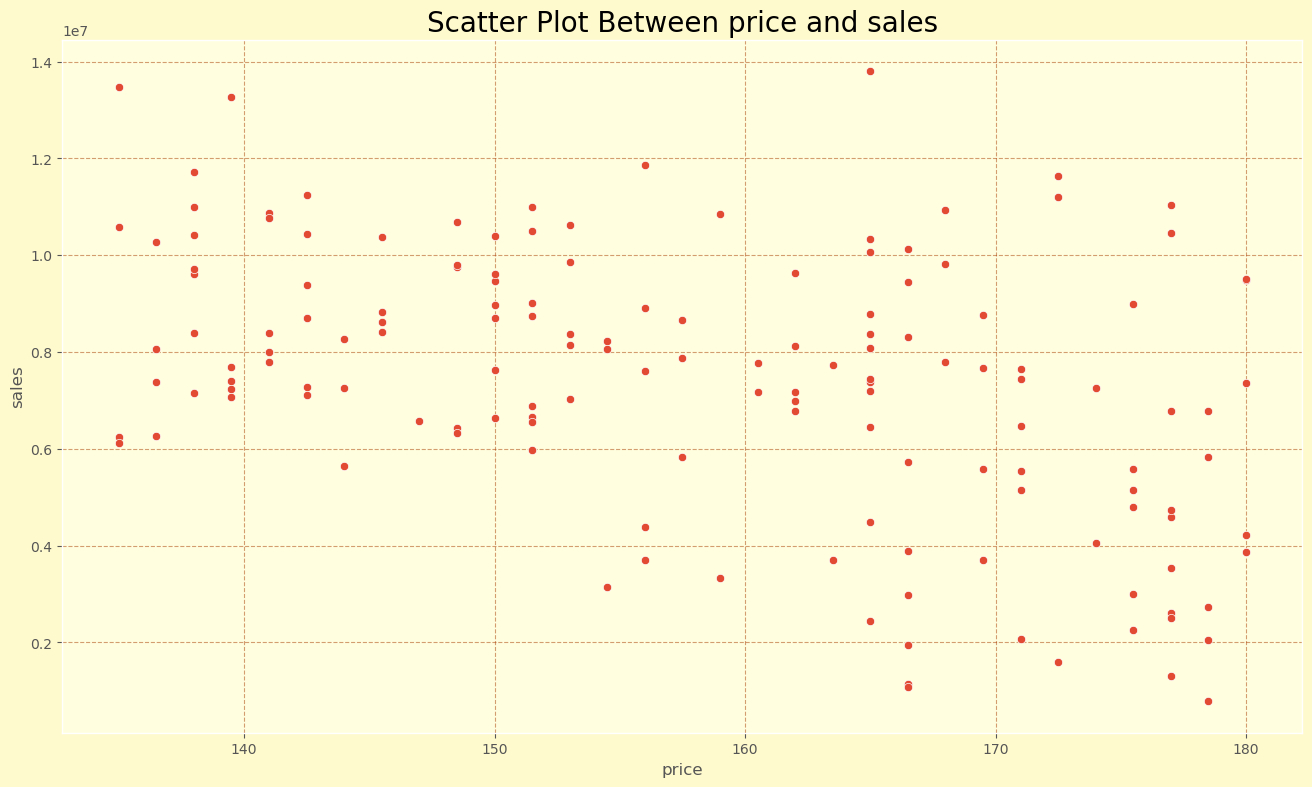

In [44]:
#scatter plot 
for feature in features:
    plt.figure()
    g = sns.scatterplot(x=feature, y='sales', data=df)
    g.set_title(f'Scatter Plot Between {feature} and sales',fontsize=20)
    
  
    plt.savefig(f'./Scatter Plot Between {feature} and sales.jpg',format='jpeg',
                   dpi=300,
                   bbox_inches='tight')

<Figure size 1600x900 with 0 Axes>

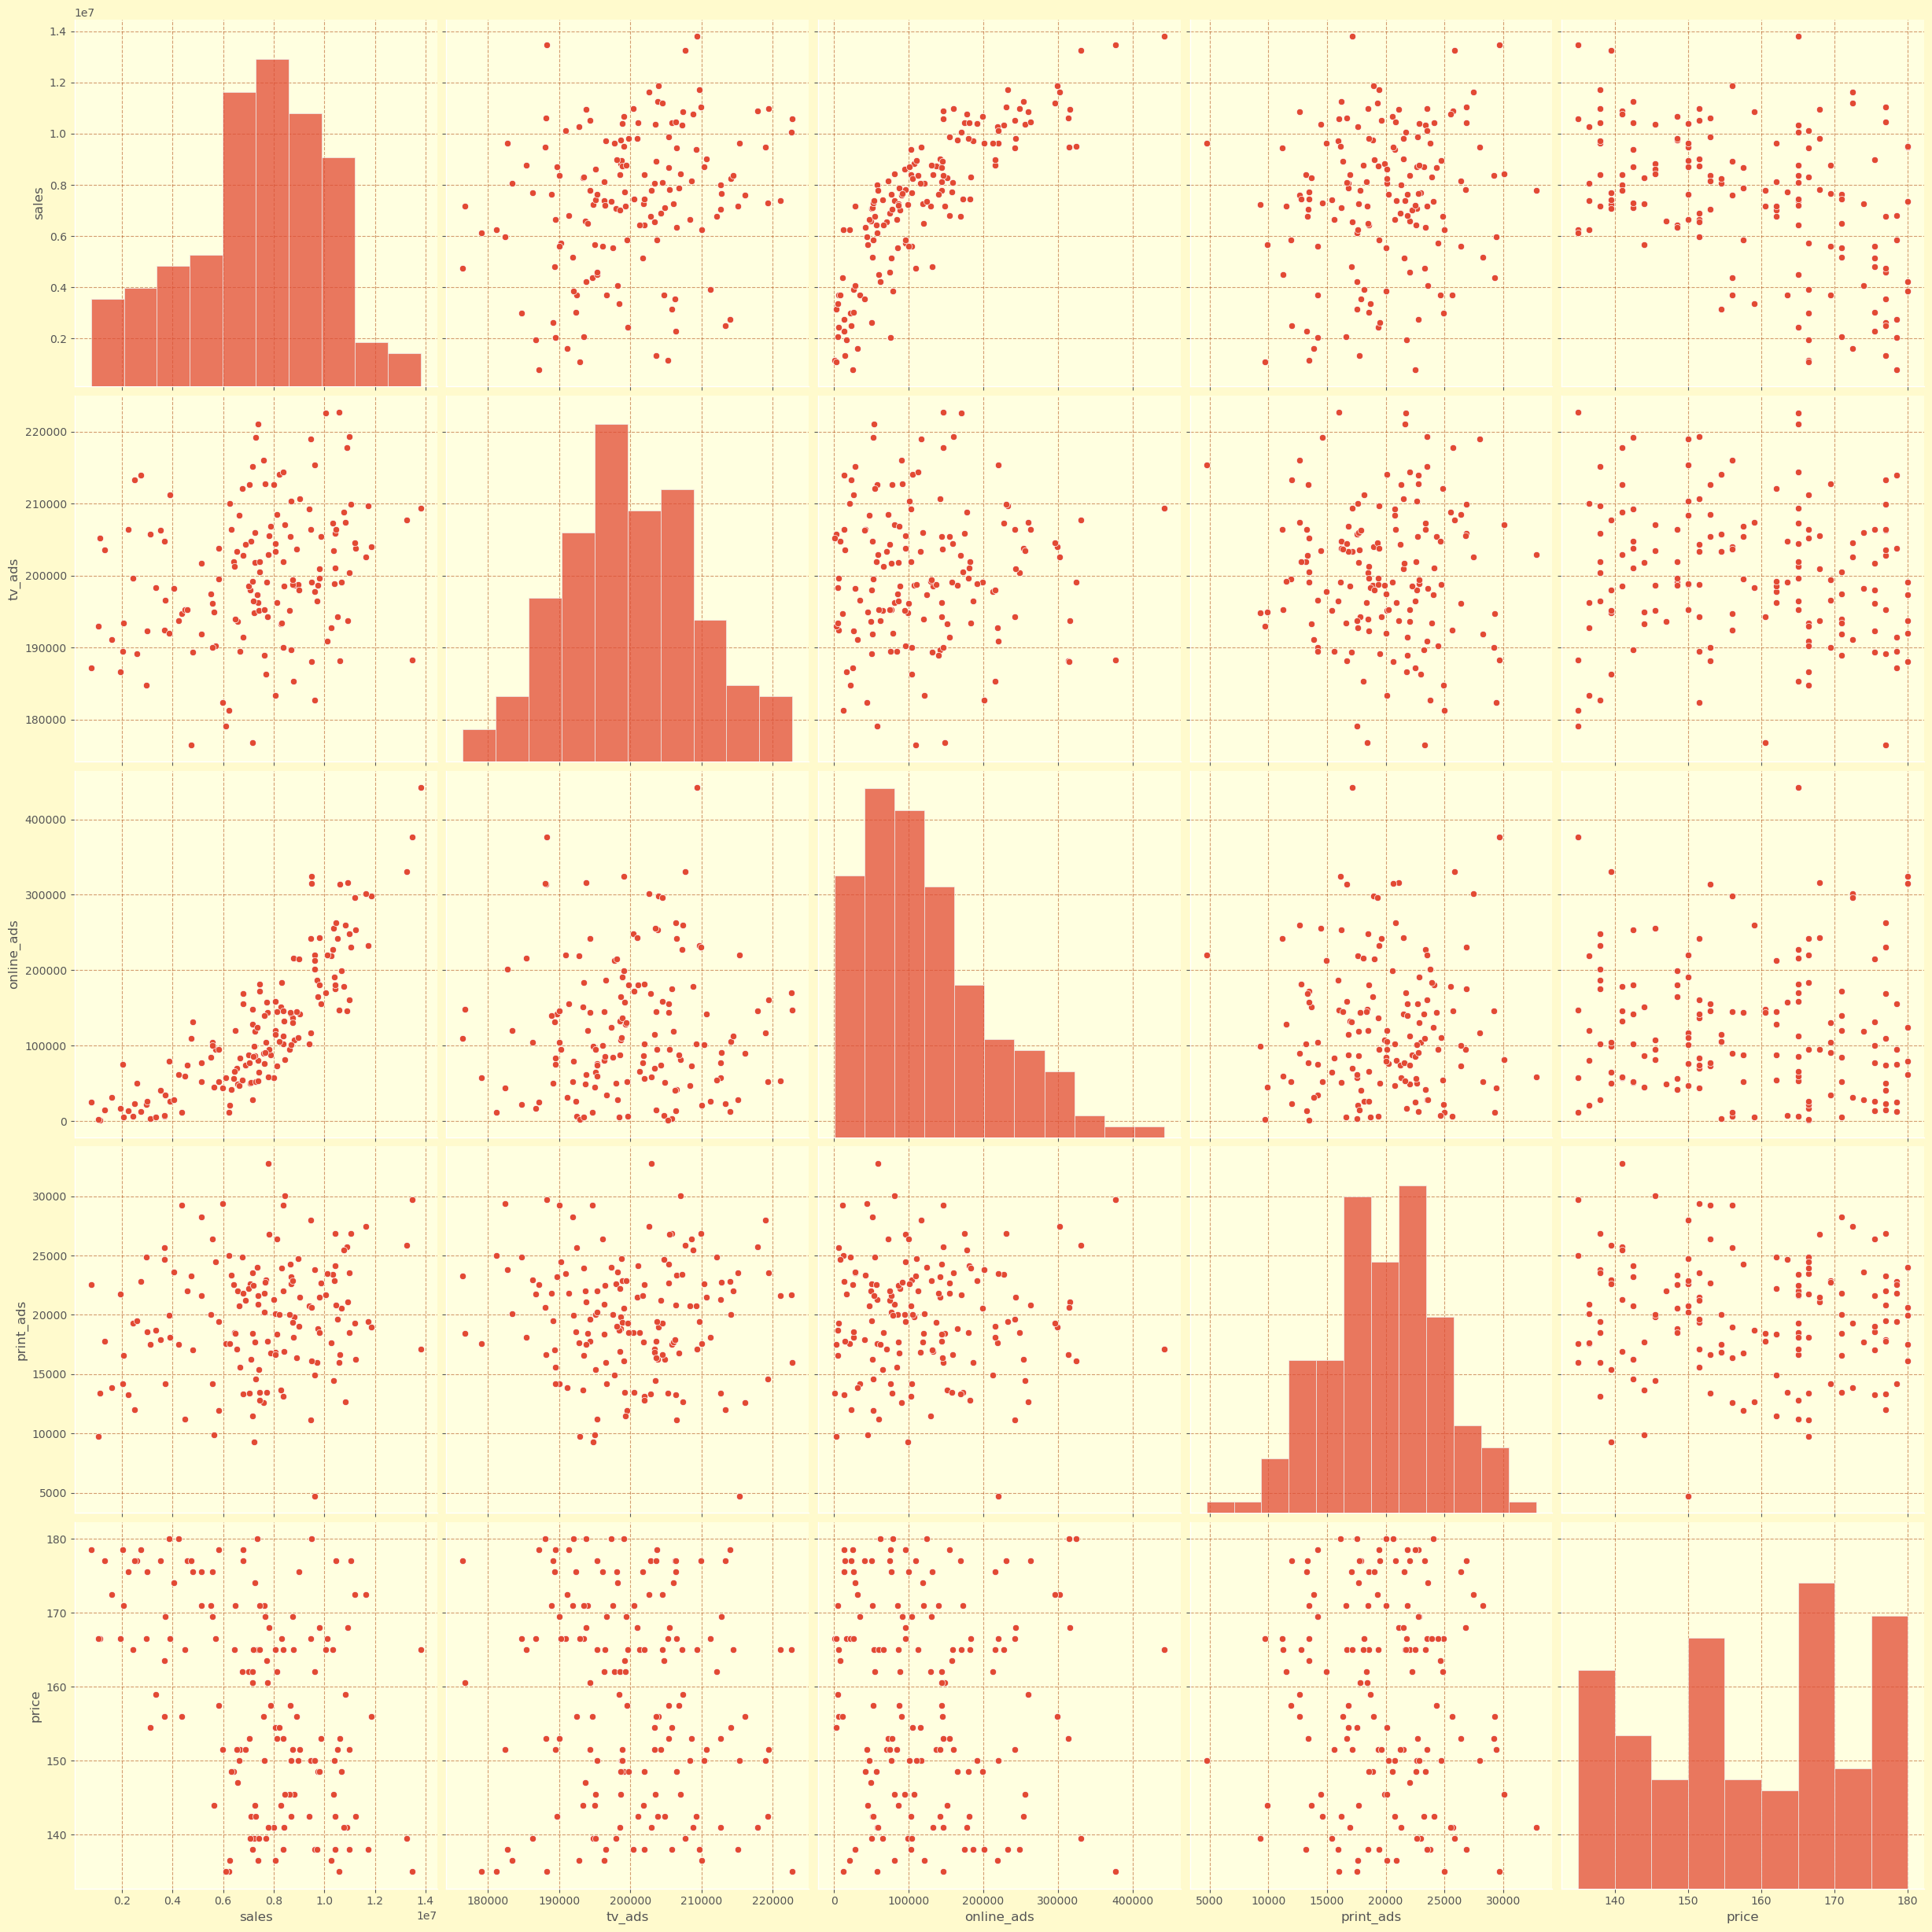

In [45]:
# pair plot
plt.figure()
g = sns.pairplot(df, height=5)
plt.show()

g.savefig(f'./pairplot.jpg',format='jpeg',
           dpi=300,
           bbox_inches='tight')


**Insights:** 'in_store_advertising' and 'billboard_advertising' have somwehat linear relationship with 'sales

## 2.4 Correlation Matrix 

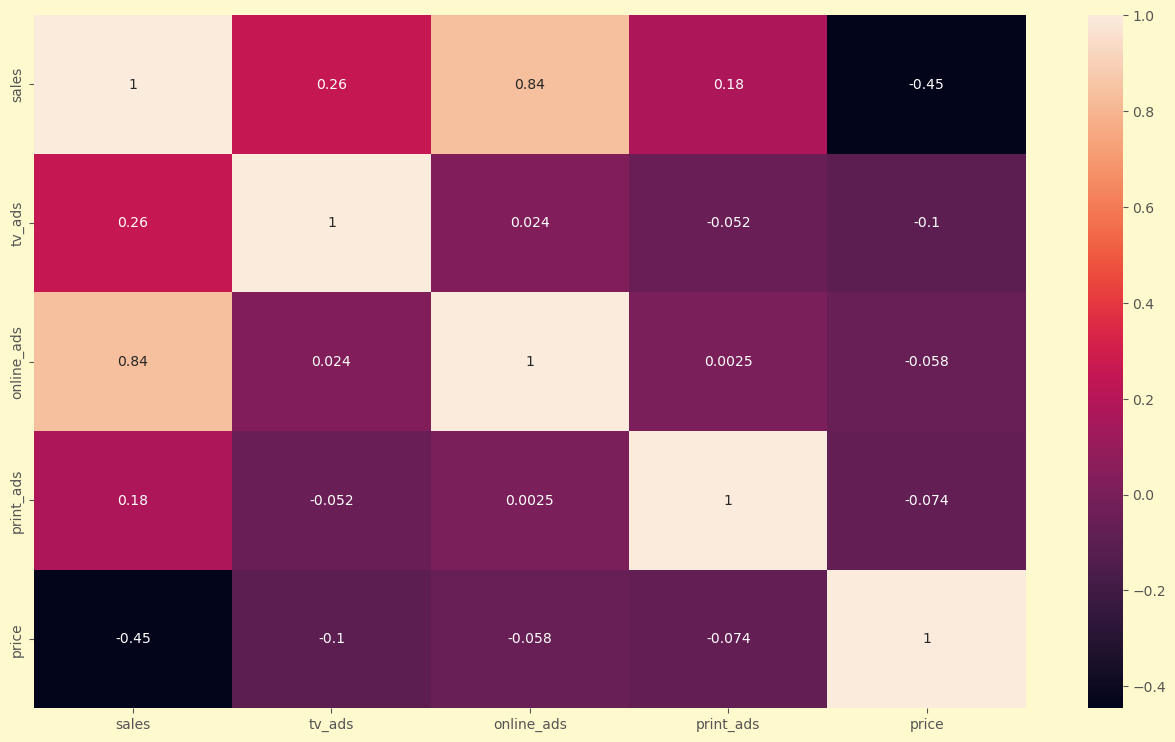

In [46]:
#correlation matrix
corrmat = df.corr()

g = sns.heatmap(corrmat, annot=True)


g.get_figure().savefig(f'./correlation_matrix.jpg',format='jpeg',
                       dpi=300,
                       bbox_inches='tight')

**Insights: \
a: No clear correlation between dependent variables \
b: Strong correlarion with 'sales': 'in_store_advertising' & 'billboard_advertising';  Medium correlarion with 'sales': 'satisfaction' & 'price'**


## 2.5 Probability plot for all independent variables

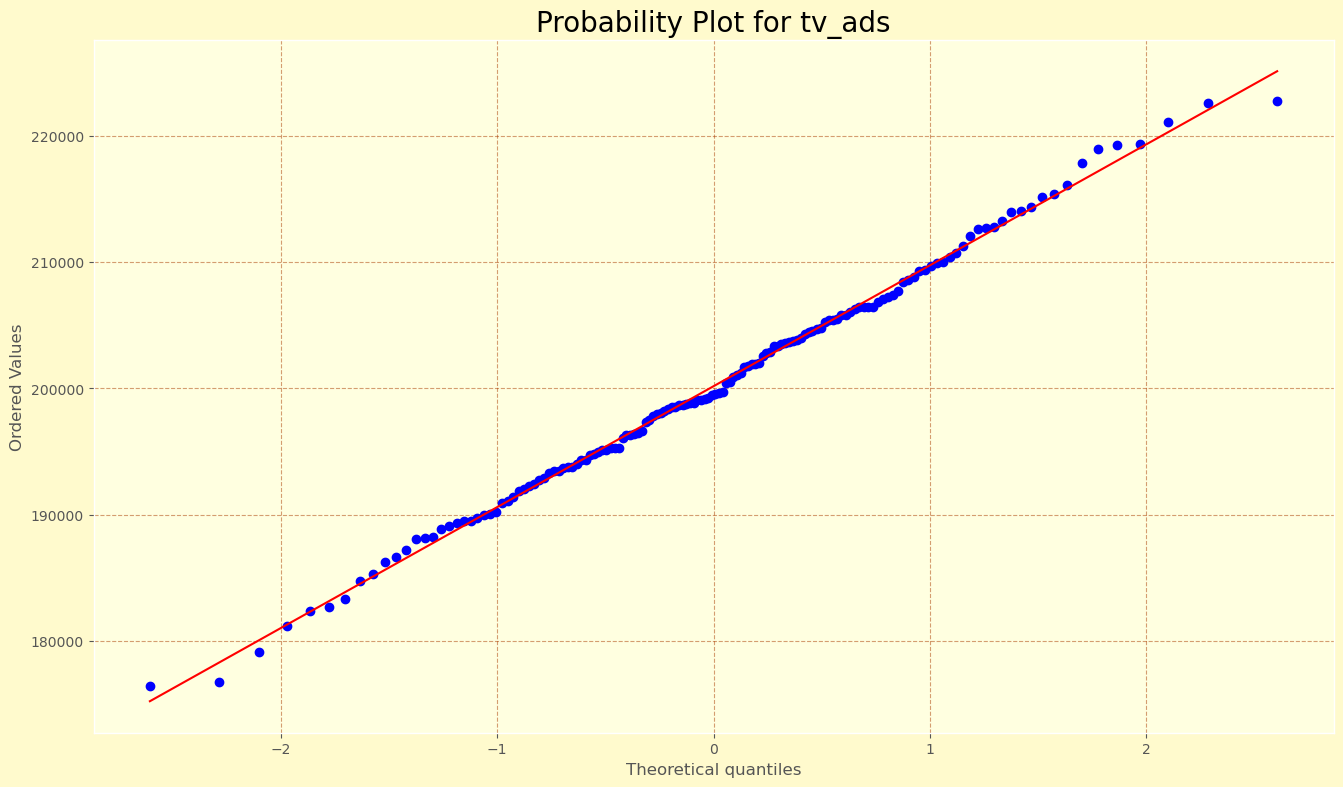

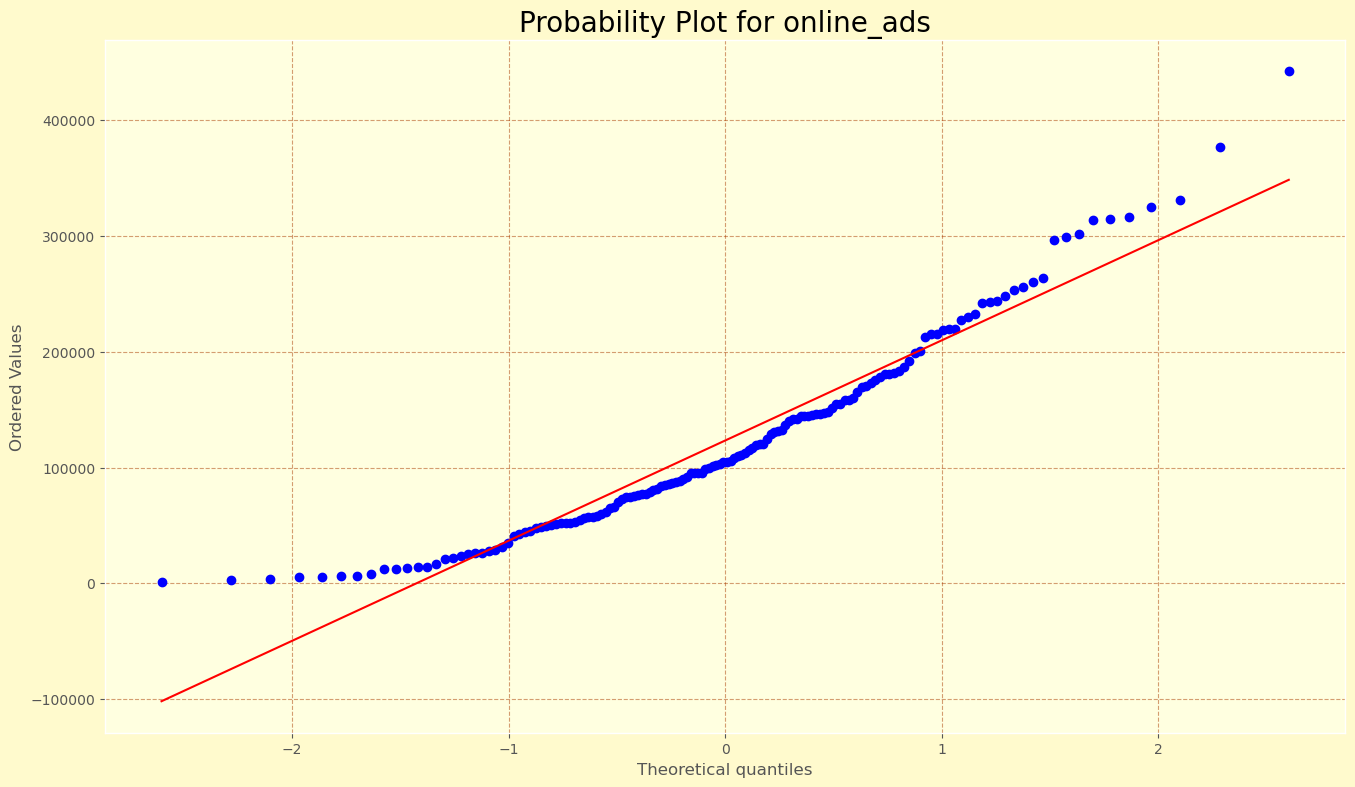

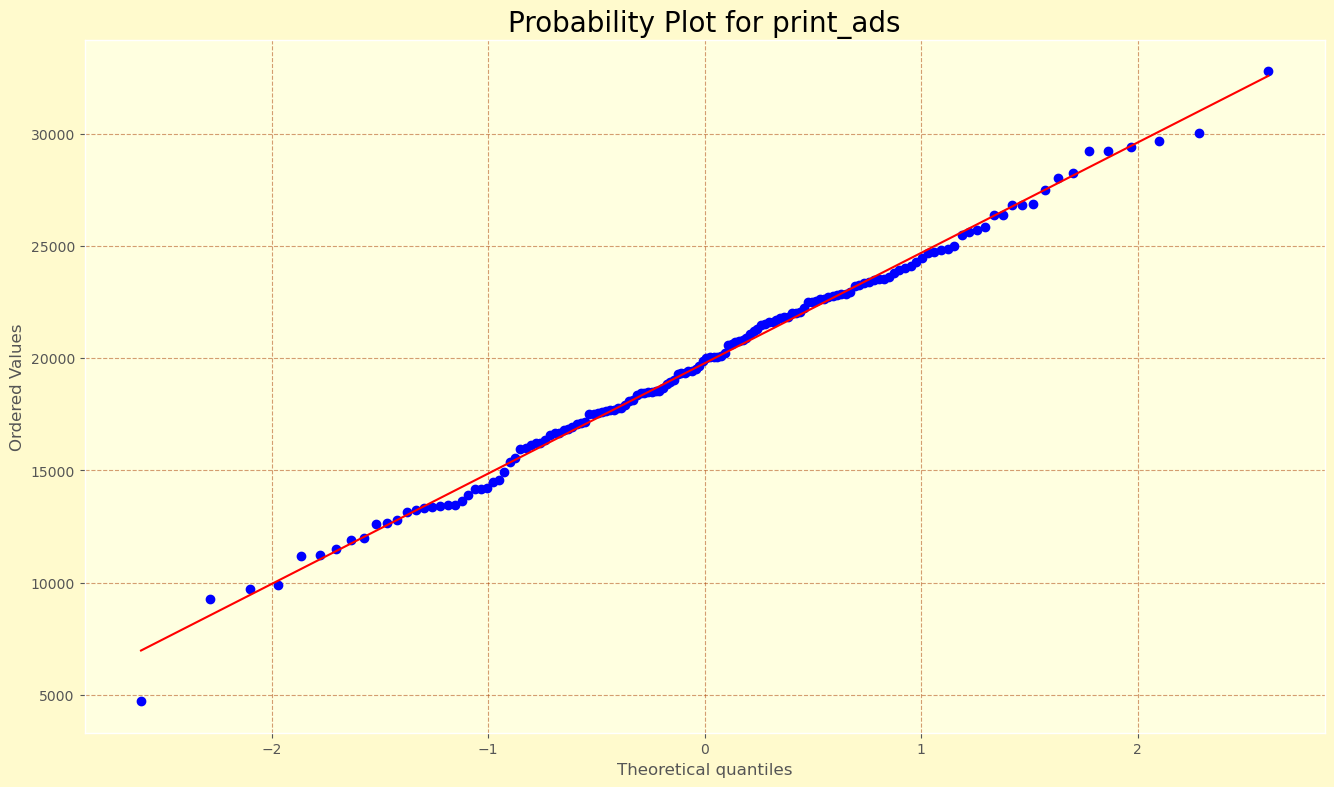

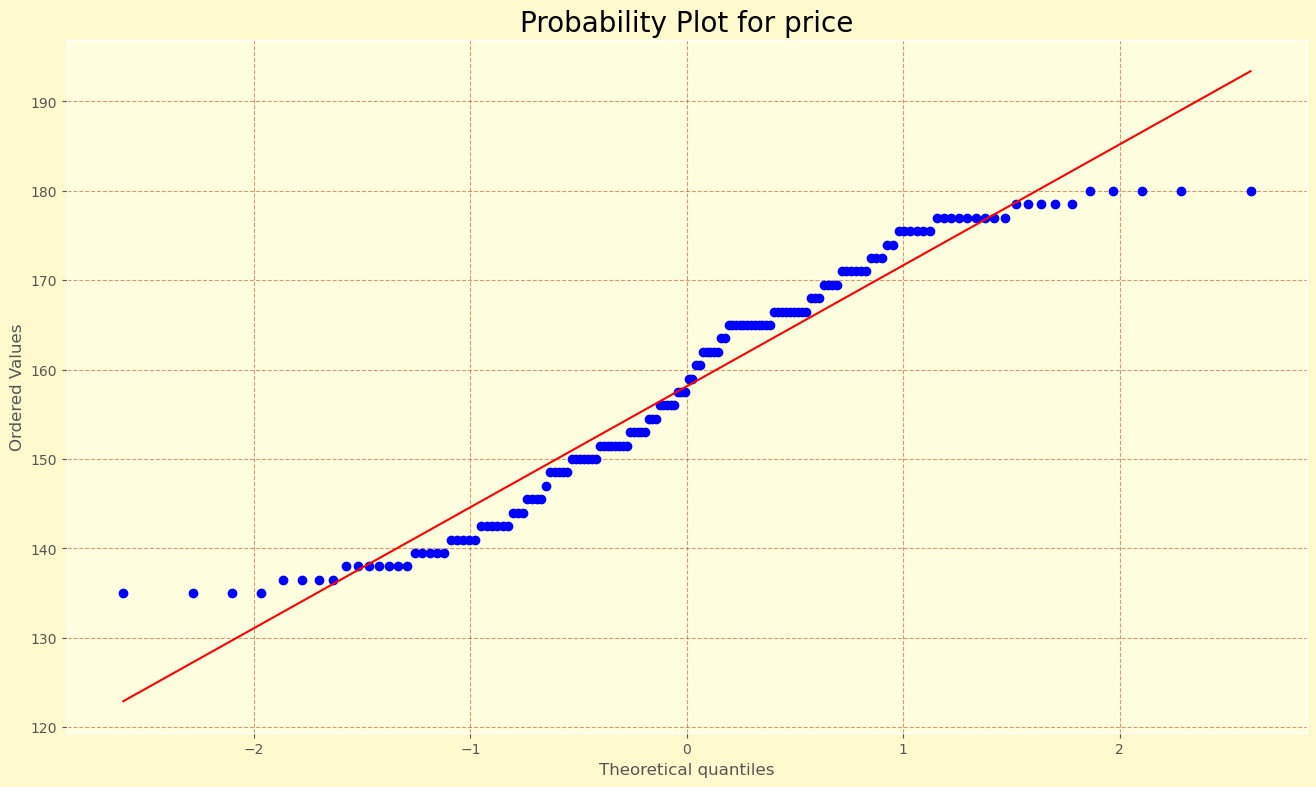

In [43]:
#prob plot 
for feature in features:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    res = stats.probplot(df[feature], plot=ax)
    ax.set_title(f'Probability Plot for {feature}',fontsize=20)

# 3. Train Test Split

In [71]:
columns = ['tv_ads', 'online_ads', 'print_ads', 'price']

In [72]:
x_train,x_test,y_train,y_test = train_test_split(df[features], df['sales'], 
                                                test_size = 0.25,random_state=42)

# Reset Index
for dataset in [x_train,x_test,y_train,y_test]:
    dataset.reset_index(drop=True,inplace=True)

In [75]:
x_train.head()

,tv_ads,online_ads,print_ads,price
0,210038.2897,21297.5732,17606.9914,136.5000
1,201788.0037,86330.8378,17709.8718,144.0000
2,213953.8933,13210.8018,22804.3584,178.5000
3,199131.2144,158031.7033,13479.9306,163.5000
4,199641.8878,6279.7671,19334.8442,165.0000


# 4. Build parametric models

## 4.1 Basic linear regression

In [49]:
# Build basic linear regression model
x_train_lr1 = sm.add_constant(x_train)
x_test_lr1 = sm.add_constant(x_test)

lr1 = sm.OLS(y_train,x_train_lr1)
lr1 = lr1.fit()
print ("\n \n",lr1.summary())


 
                             OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     301.0
Date:                Thu, 09 May 2024   Prob (F-statistic):           3.00e-57
Time:                        18:07:30   Log-Likelihood:                -1680.7
No. Observations:                 112   AIC:                             3371.
Df Residuals:                     107   BIC:                             3385.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.191e+06   1.95e+06      1.124     

**Insights:** Intercept and 'print_advertising' are insignificant. "If the intercept is not significant you usually would not want to remove it from the model because by doing this you are creating a model that says that the response function must be zero when the predictors are all zero."(https://support.sas.com/kb/23/136.html)

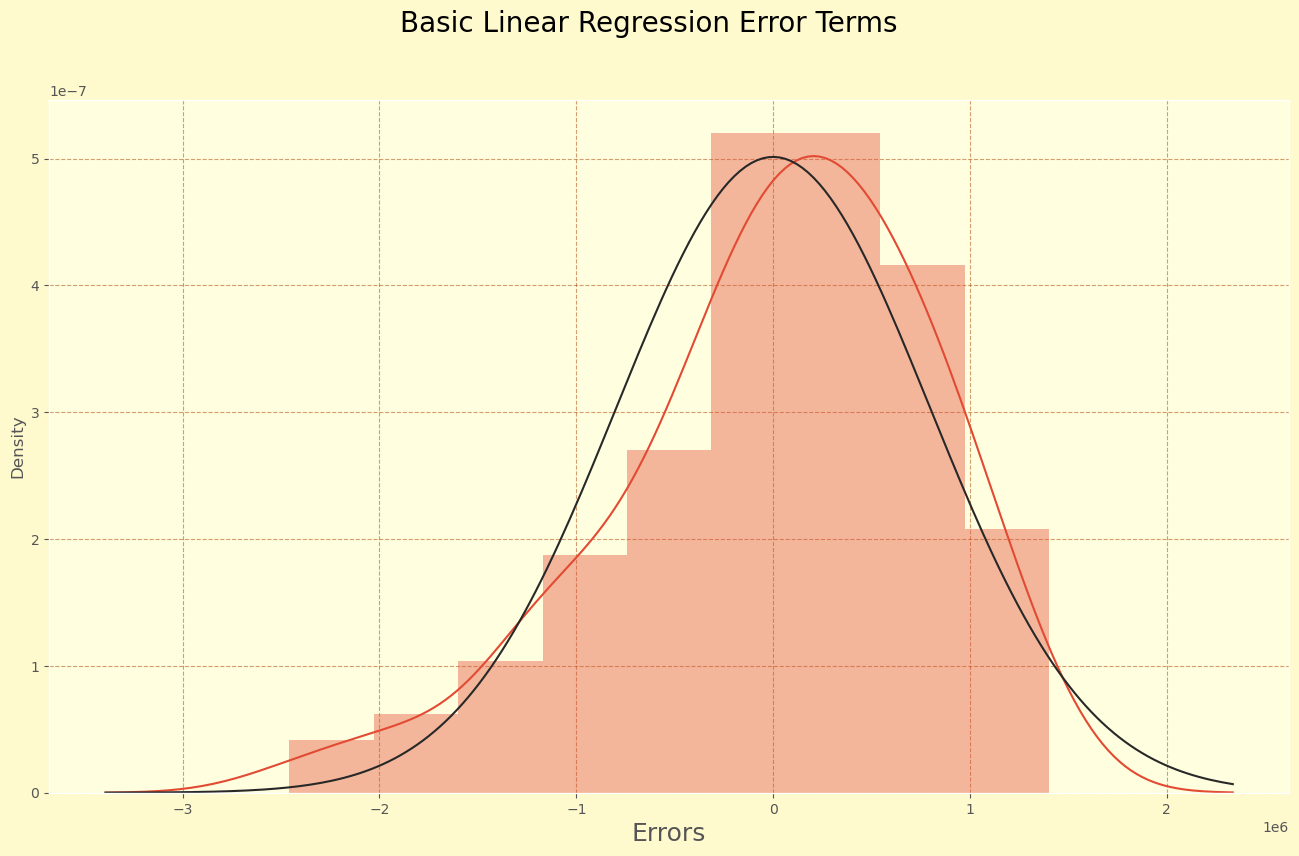

In [51]:
# Plot the histogram of the error terms
y_train_pred_lr1 = lr1.predict(x_train_lr1)
error1 = y_train-y_train_pred_lr1

fig = plt.figure()
sns.distplot(error1, fit=norm)
fig.suptitle('Basic Linear Regression Error Terms', fontsize = 20) 
plt.xlabel('Errors', fontsize = 18)    
plt.show()

fig.savefig(f'./chart/Basic Linear Regression Error Terms.jpg',format='jpeg',
           dpi=300,
           bbox_inches='tight')

**Insights:** Residuals are normally distributed. Hence the assumption for linear regression is valid.

In [52]:
# Check multi-collinearity
print ("\033[1mVariance Inflation Factor\033[0m(Normally VIF <= 4 suggests no multi-collinearity):")
cnames = x_train.columns
for i in np.arange(0,len(cnames)):
    xvars = list(cnames)
    yvar = xvars.pop(i)
    lr = sm.OLS(x_train[yvar],sm.add_constant(x_train[xvars]))
    res = lr.fit()
    vif = 1/(1-res.rsquared)
    print(f'{yvar}: \033[1m{vif:.4f}\033[0m')

Variance Inflation Factor(Normally VIF <= 4 suggests no multi-collinearity):
tv_ads: 1.0085
online_ads: 1.0034
print_ads: 1.0089
price: 1.0099


In [53]:
# Check model performance on test dataset
y_pred_lr1 = lr1.predict(x_test_lr1)
mse_lr1 = mean_squared_error(y_test, y_pred_lr1)
r2_lr1 = r2_score(y_test, y_pred_lr1)
print(f"mse for basic linear regression on test data is: \033[1m{mse_lr1:.4f}\033[0m")
print(f"r2 for basic linear regression on test data is: \033[1m{r2_lr1:.4f}\033[0m")

mse for basic linear regression on test data is: 591345453351.3766
r2 for basic linear regression on test data is: 0.9236


## 4.2 Linear regression with interactions & Backward Elimination

In [76]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split


# Applying polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
x_train_interaction = poly.fit_transform(x_train)

# Creating new column names based on polynomial feature interactions
new_column_names = poly.get_feature_names_out(input_features=features)

# Updating column names in the DataFrame for the training set
x_train_interaction = pd.DataFrame(x_train_interaction, columns=new_column_names)

# Applying the same transformation to the test set
x_test_interaction = poly.transform(x_test)
x_test_interaction = pd.DataFrame(x_test_interaction, columns=new_column_names)

# Display the DataFrame with new feature names for the training set
print(x_train_interaction.head())

       tv_ads  online_ads  print_ads    price         tv_ads^2  tv_ads online_ads  tv_ads print_ads  tv_ads price     online_ads^2  online_ads print_ads  online_ads price    print_ads^2  print_ads price    price^2
0 210038.2897  21297.5732 17606.9914 136.5000 44116083157.3116    4473305857.0270   3698142369.5185 28670226.5496   453586625.5206        374986189.5649      2907118.7460 310006147.5644     2403354.3315 18632.2500
1 201788.0037  86330.8378 17709.8718 144.0000 40718398438.1407   17420527407.5438   3573639666.3828 29057472.5331  7453013546.6409       1528908064.6795     12431640.6360 313639557.4238     2550221.5321 20736.0000
2 213953.8933  13210.8018 22804.3584 178.5000 45776268470.3947    2826502472.2824   4879081254.8939 38190769.9591   174525283.3569        301263857.6765      2358128.1156 520038759.9800     4070577.9664 31862.2500
3 199131.2144 158031.7033 13479.9306 163.5000 39653240567.5356   31469045007.0668   2684274959.7590 32557953.5622 24974019260.0442       2130256

In [89]:
# poly = PolynomialFeatures(interaction_only=True, include_bias=False)
# x_train_interaction = poly.fit_transform(x_train)

# # Replace get_feature_names() with get_feature_names_out() if error orrurs
# x_train_interaction = pd.DataFrame(x_train_interaction, columns = [x.replace(' ',' X ') for x in poly.get_feature_names(x_train.columns)])

# x_test_interaction = poly.transform(x_test)
# x_test_interaction = pd.DataFrame(x_test_interaction, columns = [x.replace(' ',' X ') for x in poly.get_feature_names(x_test.columns)])

In [77]:
display(x_train_interaction.head(1))
display(x_test_interaction.head(1))

,tv_ads,online_ads,print_ads,price,tv_ads^2,tv_ads online_ads,tv_ads print_ads,tv_ads price,online_ads^2,online_ads print_ads,online_ads price,print_ads^2,print_ads price,price^2
0,210038.2897,21297.5732,17606.9914,136.5000,44116083157.3116,4473305857.0270,3698142369.5185,28670226.5496,453586625.5206,374986189.5649,2907118.7460,310006147.5644,2403354.3315,18632.2500


,tv_ads,online_ads,print_ads,price,tv_ads^2,tv_ads online_ads,tv_ads print_ads,tv_ads price,online_ads^2,online_ads print_ads,online_ads price,print_ads^2,print_ads price,price^2
0,205400.1411,144593.4332,24302.5021,157.5000,42189217955.0099,29699511576.0200,4991737349.9933,32350522.2198,20907260921.3748,3513982206.7494,22773465.7273,590611605.9769,3827644.0732,24806.2500


In [78]:
# Build linear regression model with interation features
x_train_lr2 = sm.add_constant(x_train_interaction)
x_test_lr2 = sm.add_constant(x_test_interaction)

lr2 = sm.OLS(y_train,x_train_lr2)
lr2 = lr2.fit()
print("\n \n",lr2.summary())


 
                             OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     205.8
Date:                Thu, 09 May 2024   Prob (F-statistic):           1.68e-65
Time:                        18:42:21   Log-Likelihood:                -1629.2
No. Observations:                 112   AIC:                             3288.
Df Residuals:                      97   BIC:                             3329.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 7.276e

### 4.2.1 Backward Elimination to select features

In [79]:
cols = list(x_train_interaction.columns)
while (len(cols)>0):
    data = x_train_interaction[cols]
    data = sm.add_constant(data)
    lr2 = sm.OLS(y_train,data).fit()
    
    # Get p-values from model summary
    p_list = pd.Series(lr2.pvalues.values[1:],index = cols)      
    pmax = max(p_list)
    feature_with_p_max = p_list.idxmax()
    # Kick out insignificant feature
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
        
selected_features_BE = cols
print(f'Features selected: {selected_features_BE}')
print("\n \n",lr2.summary())

Features selected: ['tv_ads price', 'online_ads^2', 'online_ads price', 'print_ads^2', 'print_ads price', 'price^2']

 
                             OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     488.3
Date:                Thu, 09 May 2024   Prob (F-statistic):           2.72e-74
Time:                        18:42:41   Log-Likelihood:                -1632.6
No. Observations:                 112   AIC:                             3279.
Df Residuals:                     105   BIC:                             3298.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
----

**Insights:** The F-Statistics value of 1219 (which is greater than 1) and the p-value of '~0.00' states that the overall model is significant

The equation of best fitted surface based on model lr2:\
sales = 16530.4608 + (**in_store_advertising** × 2.4558) - (**print_advertising** × 6.6244) + (**satisfaction** × 168.6509) − (**competitor_adversiting** × 1.5340) - (**price** × 253.7026) + (**in_store_advertising X billboard_advertising** × 0.0043) + (**billboard_advertising X satisfaction** × 0.0333) + (print_advertising X price × 0.0666)

Interpretation of Coefficients:\
in_store_advertising: A coefficient value of '2.455' indicated that a unit increase in in_store_advertising, increases the sales by 2.455 units.

In [81]:
# Prepare new data with selected features
x_train_lr2 = sm.add_constant(x_train_interaction[selected_features_BE])
x_test_lr2 = sm.add_constant(x_test_interaction[selected_features_BE])

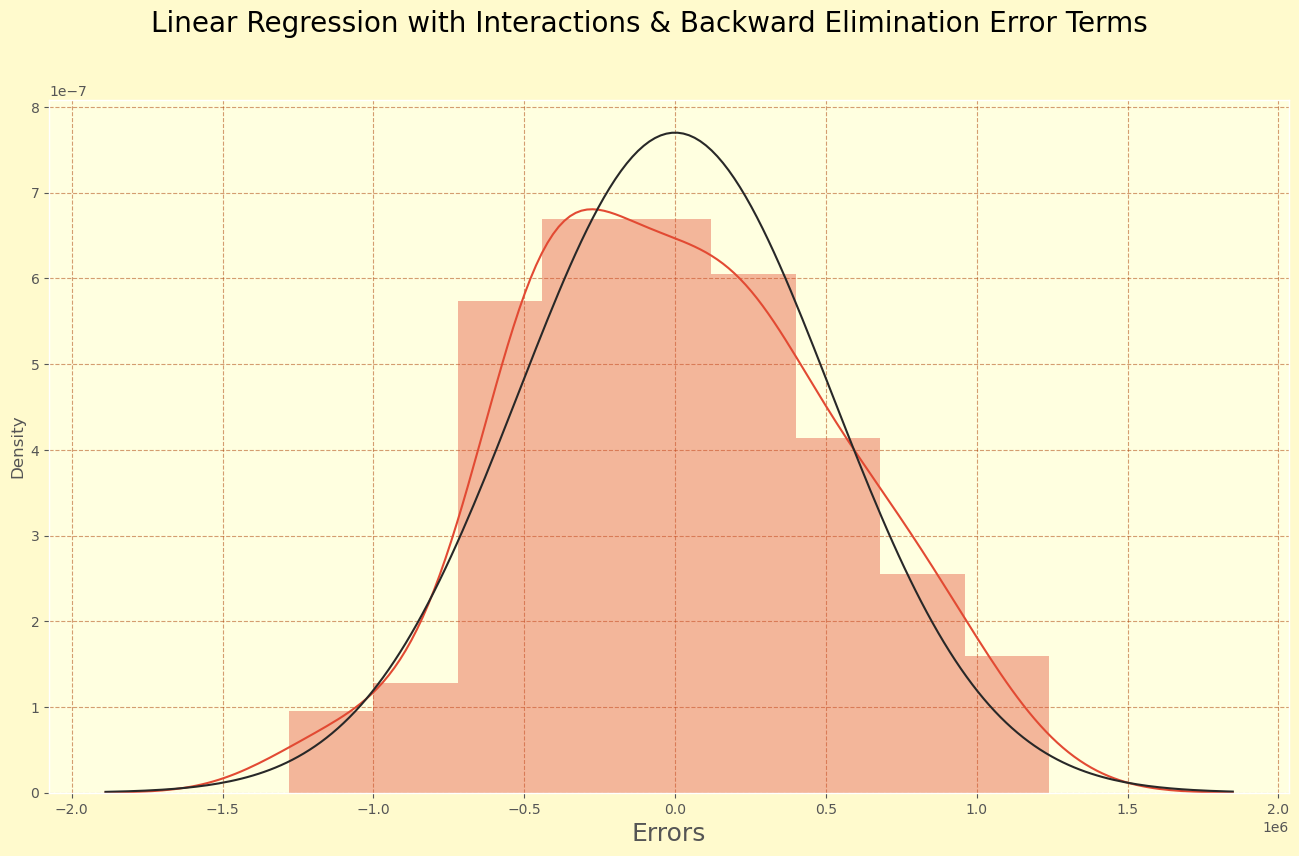

In [82]:
# Plot the histogram of the error terms
y_train_pred_lr2 = lr2.predict(x_train_lr2)
error2 = y_train-y_train_pred_lr2

fig = plt.figure()
sns.distplot(error2, fit=norm)
fig.suptitle('Linear Regression with Interactions & Backward Elimination Error Terms', fontsize = 20) 
plt.xlabel('Errors', fontsize = 18)    
plt.show()

fig.savefig(f'./chart/Linear Regression with Interactions & Backward Elimination Error Terms.jpg',format='jpeg',
           dpi=300,
           bbox_inches='tight')

In [83]:
# Check model performance on test dataset
y_pred_lr2 = lr2.predict(x_test_lr2)
mse_lr2 = mean_squared_error(y_test, y_pred_lr2)
r2_lr2 = r2_score(y_test, y_pred_lr2)
print(f"mse for linear regression with interactions & backward elimination on test data is: \033[1m{mse_lr2:.4f}\033[0m")
print(f"r2 for linear regression with interactions & backward elimination on test data is: \033[1m{r2_lr2:.4f}\033[0m")

mse for linear regression with interactions & backward elimination on test data is: 288956538138.6466
r2 for linear regression with interactions & backward elimination on test data is: 0.9627


## 4.3 Linear regression with interactions & Lasso

### 4.3.1 Find Optimal Alpha for Lasso

In [84]:
alpharange = np.logspace(-10,1,1000,base=10)
alpharange.shape

(1000,)

In [85]:
lr3 = LassoCV(alphas=alpharange, cv=5).fit(x_train_interaction,y_train)

In [86]:
print(f'Optimal alpha for LASSO is \033[1m{lr3.alpha_:.6f}\033[0m')

Optimal alpha for LASSO is 10.000000


In [87]:
print ("\033[1mLasso Regression intercept value:\033[0m",lr3.intercept_)
print ("\n\033[1mLasso Regression coefficient values:\033[0m")
for i in range(len(x_train_interaction.columns)):
    print (x_train_interaction.columns[i],": ",lr3.coef_[i])

Lasso Regression intercept value: 5845697.951987133

Lasso Regression coefficient values:
tv_ads :  -45.0934502420415
online_ads :  -1.0824885460420357
print_ads :  -64.84932500938031
price :  61788.62791236432
tv_ads^2 :  2.2101232362181017e-05
tv_ads online_ads :  2.3013496740640237e-05
tv_ads print_ads :  -0.0001496565512504984
tv_ads price :  0.5905979902179797
online_ads^2 :  -4.457507623293994e-05
online_ads print_ads :  0.00017673682330390211
online_ads price :  0.20913478296246854
print_ads^2 :  -0.002316789074408913
print_ads price :  1.6336398537935968
price^2 :  -989.3316256344874


In [88]:
# Check model performance on test dataset
y_pred_lr3 = lr3.predict(x_test_interaction)

mse_lr3 = mean_squared_error(y_test, y_pred_lr3)
r2_lr3 = r2_score(y_test, y_pred_lr3)
print(f"mse for LASSO on test data is: \033[1m{mse_lr3:.4f}\033[0m")
print(f"r2 for LASSO on test data is: \033[1m{r2_lr3:.4f}\033[0m")

mse for LASSO on test data is: 273070509922.2108
r2 for LASSO on test data is: 0.9647
